## 모듈 설치

In [1]:
# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 62.4 MB/s 
     |████████████████████████████████| 3.3 MB 50.6 MB/s 
     |████████████████████████████████| 895 kB 38.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

## 데이터 불러오기

In [3]:
news = pd.read_csv('./drive/MyDrive/final_df.csv', index_col=0) 
news.tail()

,name,headline,date,change,token_mecab
233699,SK하이닉스,"""코로나 봉쇄로 삼성 시안공장 생산 줄여…메모리 공급사 주가에는 긍정적 영향""",2021-12-30,1,코로나 봉쇄 삼성 시안 공장 생산 메모리 공급 주가 긍정 영향
233700,SK하이닉스,"SK하이닉스, 인텔 낸드 1단계 인수",2021-12-30,1,SK 하이닉스 인텔 낸드 단계 인수
233701,SK하이닉스,"SK하이닉스, 특별성과급 300% 쏜다",2021-12-30,1,SK 하이닉스 특별
233702,셀트리온,"삼성바이오로직스-셀트리온, 바이오 대장주 희비",2021-12-30,0,삼성 바이오 로직스 트리 장주 희비
233703,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0,배당락 코스피 하락 예상


In [4]:
news.date = news.date.astype('datetime64[ns]') # 데이터 타입 변경

In [5]:
news['date'] = pd.to_datetime(news['date'])

split_date = pd.to_datetime('2020-01-01')

train = news[news['date'] < split_date]
test = news[news['date'] >= split_date]

In [6]:
len(train), len(test)

(188530, 45174)

In [7]:
train.dropna(how='any', inplace=True)
test.dropna(how='any', inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
train.reset_index(inplace=True); test.reset_index(inplace=True)

In [9]:
train.drop(columns='index', axis=1, inplace=True) # index 열 제거
test.drop(columns='index', axis=1, inplace=True) # index 열 제거

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
train = train[['date', 'name', 'headline', 'change']] # 필요한 열만
test = test[['date', 'name', 'headline', 'change']] # 필요한 열만

In [11]:
train.head()

,date,name,headline,change
0,2012-01-02,삼성전자,"[TV] 재계 총수들, 일자리 창출과 투자 확대 강조",1
1,2012-01-02,셀트리온,"코스닥, 새해 첫 거래일 소폭 오름세 지속",0
2,2012-01-02,셀트리온,코스닥 새해 첫 거래일 소폭 오름세 지속,0
3,2012-01-02,셀트리온,"코스닥, 개인·기관 '사자'에 상승 지속…저출산株 강세",0
4,2012-01-02,셀트리온,"코스피, 외인 '팔자'에 약세 전환…방향성 탐색",0


## 전처리 - train

In [12]:
# 헤드라인 문장 추출
sentences = train['headline']
sentences[:10]

0           [TV] 재계 총수들, 일자리 창출과 투자 확대 강조
1                 코스닥, 새해 첫 거래일 소폭 오름세 지속
2                  코스닥 새해 첫 거래일 소폭 오름세 지속
3          코스닥, 개인·기관 '사자'에 상승 지속…저출산株 강세
4              코스피, 외인 '팔자'에 약세 전환…방향성 탐색
5            코스닥, 2012년 첫 거래일 상승세..0.91%↑
6              코스닥, 새해 첫 거래일 개인 매수에 3.7p↑
7    [IR52 장영실상] LG화학, 일회용장갑 소재 `NBR 라텍스`
8        [2012년 주목할 CEO 12인] 김반석 LG화학 부회장
9                               정유·화학주 하락
Name: headline, dtype: object

In [13]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] [TV] 재계 총수들, 일자리 창출과 투자 확대 강조 [SEP]',
 '[CLS] 코스닥, 새해 첫 거래일 소폭 오름세 지속 [SEP]',
 '[CLS] 코스닥 새해 첫 거래일 소폭 오름세 지속 [SEP]',
 "[CLS] 코스닥, 개인·기관 '사자'에 상승 지속…저출산株 강세 [SEP]",
 "[CLS] 코스피, 외인 '팔자'에 약세 전환…방향성 탐색 [SEP]",
 '[CLS] 코스닥, 2012년 첫 거래일 상승세..0.91%↑ [SEP]',
 '[CLS] 코스닥, 새해 첫 거래일 개인 매수에 3.7p↑ [SEP]',
 '[CLS] [IR52 장영실상] LG화학, 일회용장갑 소재 `NBR 라텍스` [SEP]',
 '[CLS] [2012년 주목할 CEO 12인] 김반석 LG화학 부회장 [SEP]',
 '[CLS] 정유·화학주 하락 [SEP]']

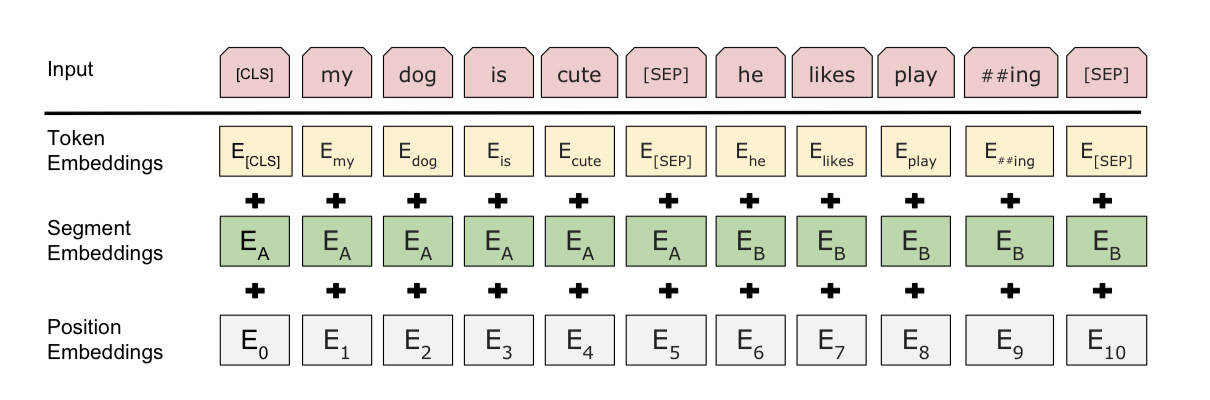

- BERT의 입력은 위의 그림과 같은 형식 
- Classification을 뜻하는 [CLS] 심볼이 제일 앞에 삽입됨 
- 파인튜닝시 출력에서 이 위치의 값을 사용하여 분류를 함 
- [SEP]은 Seperation을 가리키는데, 두 문장을 구분하는 역할
- 헤드라인 문장은 하나이므로 [SEP]도 하나만 넣어줌

In [14]:
# 라벨 추출
labels = train['change'].values
labels

array([1, 0, 0, ..., 0, 1, 1])

In [15]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print(sentences[0])
print(tokenized_texts[0])

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

[CLS] [TV] 재계 총수들, 일자리 창출과 투자 확대 강조 [SEP]
['[CLS]', '[', 'TV', ']', '재', '##계', '총', '##수', '##들', ',', '일', '##자', '##리', '창', '##출', '##과', '투', '##자', '확', '##대', '강', '##조', '[SEP]']


- BERT는 형태소분석으로 토큰을 분리하지 않음 
- WordPiece라는 통계적인 방식을 사용 
- 한 단어내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듬 
- 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있음 
- 또한 신조어 같이 사전에 없는 단어를 처리하기도 좋음

- 위의 결과에서 '##' 기호는 앞 토큰과 이어진다는 표시 
- 토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingual-cased'를 사용 
- 그래서 한글도 처리가 가능

In [16]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 64

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([  101,   164, 10813,   166,  9659, 21611,  9761, 15891, 27023,
         117,  9641, 13764, 12692,  9736, 52363, 11882,  9881, 13764,
        9994, 14423,  8853, 20626,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

- 보통 딥러닝 모델에는 토큰 자체를 입력으로 넣을 수 없음 
- 임베딩 레이어에는 토큰을 숫자로 된 인덱스로 변환하여 사용 
- BERT의 토크나이저는 {단어토큰:인덱스}로 구성된 단어사전을 가지고 있음 
- 이를 참조하여 토큰을 인덱스로 바꿈

In [17]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2022, 
                                                                                    test_size=0.2)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2022, 
                                                       test_size=0.2)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9812,  12605, 118770,    117,  31977,  18471,    112,   9318,
        119236,    112,    100,  17280,   9942,  27654,  21876,   4575,    112,
          8985,  21789,    112,    102,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])
tensor(1)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([   101,   9632,  25549,  14279,   8888, 119122,   9568, 118989,   8940,
         12030,  11903,    100,   8908,  206

In [19]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## 모델 생성

In [31]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [32]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [34]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

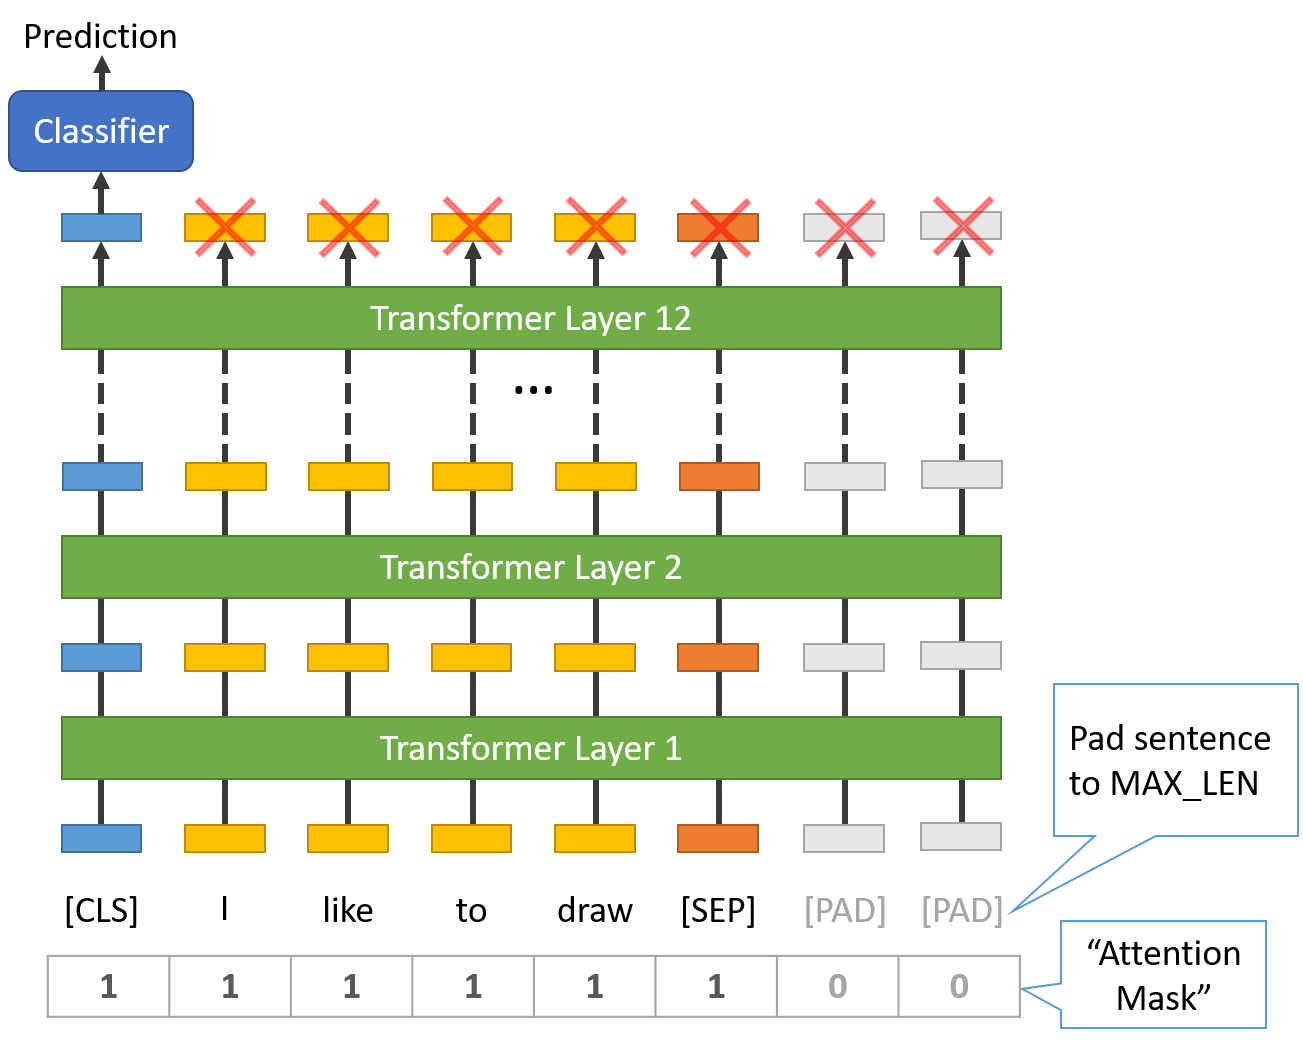

- 사전훈련된 BERT는 다양한 문제로 전이학습이 가능
- 여기서는 위 그림과 같이 한 문장을 분류하는 방법을 사용(헤드라인) 
- 헤드라인 문장이 입력으로 들어가면, 긍정(상승)/부정(하락)으로 구분 
- 모델의 출력에서 [CLS] 위치인 첫 번째 토큰에 새로운 레이어를 붙여서 파인튜닝
- Huggning Face는 BertForSequenceClassification() 함수를 제공하기 때문에 쉽게 구현할 수 있음

In [35]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## 모델 학습

In [28]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [36]:
# 재현을 위해 랜덤시드 고정
seed_val = 13
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  4,713.    Elapsed: 0:01:49.
  Batch 1,000  of  4,713.    Elapsed: 0:03:39.
  Batch 1,500  of  4,713.    Elapsed: 0:05:28.
  Batch 2,000  of  4,713.    Elapsed: 0:07:17.
  Batch 2,500  of  4,713.    Elapsed: 0:09:06.
  Batch 3,000  of  4,713.    Elapsed: 0:10:55.
  Batch 3,500  of  4,713.    Elapsed: 0:12:44.
  Batch 4,000  of  4,713.    Elapsed: 0:14:33.
  Batch 4,500  of  4,713.    Elapsed: 0:16:22.

  Average training loss: 0.69
  Training epcoh took: 0:17:09

Running Validation...
  Accuracy: 0.53
  Validation took: 0:01:14

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  4,713.    Elapsed: 0:01:49.
  Batch 1,000  of  4,713.    Elapsed: 0:03:38.
  Batch 1,500  of  4,713.    Elapsed: 0:05:27.
  Batch 2,000  of  4,713.    Elapsed: 0:07:16.
  Batch 2,500  of  4,713.    Elapsed: 0:09:05.
  Batch 3,000  of  4,713.    Elapsed: 0:10:55.
  Batch 3,500  of  4,713.    Elapsed: 0:12:44.
  Batch 4,000  of  4,713.    Elap

## test set 평가

In [46]:
test['headline']

0                              "기술 사대주의로는 AI 정복 힘들다"
1           [해설]中 디지털 종속 우려...동남아 국가 '中 QR결제 금지' 초강수
2             씨티은행, 1.3%포인트 금리인하 직장인 신용대출..한달 연장 이벤트
3                              '소비자분쟁 통지서' 카톡으로 제공된다
4                      [이슈분석]키 잡은 공정위…배민-DH 합병 경우의 수
                            ...                     
45167    "코로나 봉쇄로 삼성 시안공장 생산 줄여…메모리 공급사 주가에는 긍정적 영향"
45168                           SK하이닉스, 인텔 낸드 1단계 인수
45169                          SK하이닉스, 특별성과급 300% 쏜다
45170                      삼성바이오로직스-셀트리온, 바이오 대장주 희비
45171             배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”
Name: headline, Length: 45172, dtype: object

### 전처리 - test

In [51]:
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 64

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [52]:
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [53]:
from tqdm import tqdm

predict_list = [] # 예측 값 담기
for sentence in tqdm(test['headline']):
    predict_list.append(np.argmax(test_sentences([sentence])))

100%|██████████| 45172/45172 [10:05<00:00, 74.64it/s]


### test set 평가 준비
- 예측기로서 동작할 수 있는 Selection Function을 만들어야함
- 특정날짜의 주가 기사문장이 N개라고 했을 때, N개의 문장의 감성 분류스코어를 계산한 확률평균을 그날 주식 종가의 업다운을 결정하는 예측 값으로 사용
- 문장 판별 확률의 평균으로 선택한 이유 -> 일반화된 테스트 데이터가 아님

In [63]:
test['predict'] = predict_list
test.head()

,date,name,headline,change,predict
0,2020-01-02,카카오,"""기술 사대주의로는 AI 정복 힘들다""",0,0
1,2020-01-02,카카오,[해설]中 디지털 종속 우려...동남아 국가 '中 QR결제 금지' 초강수,0,0
2,2020-01-02,카카오,"씨티은행, 1.3%포인트 금리인하 직장인 신용대출..한달 연장 이벤트",0,0
3,2020-01-02,카카오,'소비자분쟁 통지서' 카톡으로 제공된다,0,0
4,2020-01-02,카카오,[이슈분석]키 잡은 공정위…배민-DH 합병 경우의 수,0,1


In [62]:
len(test['date'].unique())

496

In [64]:
from tqdm import tqdm

stock_pred_list = []
for name in tqdm(test['name'].unique()): # 10개 종목
    temp_list = []
    for date in tqdm(test['date'].unique()): # 일자 별
        avg_pred = np.mean(test[(test['date'] == date) & (test['name'] == name)]['predict']) # 일자별 감성 확률 평균 값
        temp_list.append(avg_pred)  
    stock_pred_list.append(temp_list)

100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


In [65]:
result_df = pd.DataFrame({'카카오': stock_pred_list[0]}, index=test['date'].unique())

for idx, name in enumerate(test['name'].unique()[1:]):
    result_df[name] = stock_pred_list[idx + 1]

In [66]:
result_df.sort_index(inplace=True)

In [67]:
result_df.tail()

,카카오,SK하이닉스,KB금융,신한지주,삼성전자,셀트리온,현대차,LG화학,POSCO,NAVER
2021-12-24,0.300000,0.625000,0.000000,0.214286,0.200000,0.714286,0.333333,0.166667,0.000000,0.666667
2021-12-27,0.266667,0.583333,0.000000,NaN,0.400000,0.714286,0.363636,0.000000,0.000000,0.100000
2021-12-28,0.312500,0.666667,0.000000,0.000000,0.692308,0.666667,0.307692,0.700000,0.000000,0.333333
2021-12-29,0.200000,0.333333,0.111111,0.000000,0.545455,0.750000,0.125000,0.800000,0.000000,0.066667
2021-12-30,0.500000,0.500000,0.055556,0.428571,0.636364,0.545455,0.066667,0.375000,0.333333,0.375000


In [68]:
result_df.isnull().sum()

카카오         0
SK하이닉스      1
KB금융        4
신한지주       83
삼성전자        3
셀트리온        1
현대차         1
LG화학        1
POSCO     136
NAVER       6
dtype: int64

- 널 값을 label값과 병합 후에 처리하자

#### 종목별 정답 mapping df 생성

In [71]:
change = pd.read_csv('./drive/MyDrive/ten_change.csv', index_col=0)
change.tail()

,date,change,name
24725,2022-01-10,1,신한지주
24726,2022-01-11,1,신한지주
24727,2022-01-12,1,신한지주
24728,2022-01-13,0,신한지주
24729,2022-01-14,0,신한지주


In [72]:
change['date'] = pd.to_datetime(change['date'])

split_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-30')

change_test = change[(change['date'] >= split_date) & (change['date'] <= end_date)]

In [73]:
change_test

,date,change,name
1967,2020-01-02,0,삼성전자
1968,2020-01-03,1,삼성전자
1969,2020-01-06,0,삼성전자
1970,2020-01-07,1,삼성전자
1971,2020-01-08,1,삼성전자
...,...,...,...
24715,2021-12-24,0,신한지주
24716,2021-12-27,0,신한지주
24717,2021-12-28,1,신한지주
24718,2021-12-29,0,신한지주


In [74]:
change_df = pd.DataFrame({'삼성전자': change_test[change_test['name'] == '삼성전자']['change'].values}, index=change_test['date'].unique())
change_df.head()

,삼성전자
2020-01-02,0
2020-01-03,1
2020-01-06,0
2020-01-07,1
2020-01-08,1


In [75]:
for name in change_test['name'].unique()[1:]:
    change_df[name] = change_test[change_test['name'] == name]['change'].values

In [76]:
change_df.tail()

,삼성전자,SK하이닉스,NAVER,LG화학,현대차,카카오,셀트리온,POSCO,KB금융,신한지주
2021-12-24,1,1,1,0,1,1,0,1,0,0
2021-12-27,0,0,0,1,0,0,1,0,0,0
2021-12-28,1,1,1,1,1,1,1,1,1,1
2021-12-29,0,0,0,0,0,1,0,0,0,0
2021-12-30,0,1,0,0,0,0,0,0,0,0


#### 종목별 예측값, 정답 병합

In [77]:
change_df.columns

Index(['삼성전자', 'SK하이닉스', 'NAVER', 'LG화학', '현대차', '카카오', '셀트리온', 'POSCO',
       'KB금융', '신한지주'],
      dtype='object')

In [ ]:
# 각각 데이터프레임 생성

ten_df = []
def make_per_df(name):
  df = pd.DataFrame({'predict':result_df[name],'label': change_df[name]}, index = test['date'].unique())
  df['name'] = name
  df = df.sort_index()
  df.dropna(subset=['predict'],inplace=True)
  return df

def labeling(df):
  df['predict'][df['predict'] < 0.5] = 0
  df['predict'][df['predict'] >= 0.5] = 1
  return df


names = change_df.columns

for name in names:
  df = make_per_df(name)
  label_df = labeling(df)
  ten_df.append(label_df)

In [79]:
ten_df[3]

,predict,label,name
2020-01-02,1.0,0,LG화학
2020-01-03,0.0,0,LG화학
2020-01-06,1.0,0,LG화학
2020-01-07,1.0,1,LG화학
2020-01-08,0.0,0,LG화학
...,...,...,...
2021-12-24,0.0,0,LG화학
2021-12-27,0.0,1,LG화학
2021-12-28,1.0,1,LG화학
2021-12-29,1.0,0,LG화학


In [80]:
ten_df[2]

,predict,label,name
2020-01-02,0.0,0,NAVER
2020-01-03,0.0,0,NAVER
2020-01-06,0.0,0,NAVER
2020-01-07,1.0,1,NAVER
2020-01-08,0.0,0,NAVER
...,...,...,...
2021-12-24,1.0,1,NAVER
2021-12-27,0.0,0,NAVER
2021-12-28,0.0,1,NAVER
2021-12-29,0.0,0,NAVER


In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

%matplotlib inline

In [82]:
acc_list = []
company = ['samsung elec', 'sk hynix', 'naver', 'lg chem', 'hyundai car', 'kakao', 'celtrion', 'posco', 'kb finance', 'shinhan']
for df in ten_df:
  acc_list.append(accuracy_score(df['label'], df['predict']))

In [83]:
acc_df = pd.DataFrame({'company': company, 'accuracy': acc_list})
acc_df.set_index('company', inplace=True)

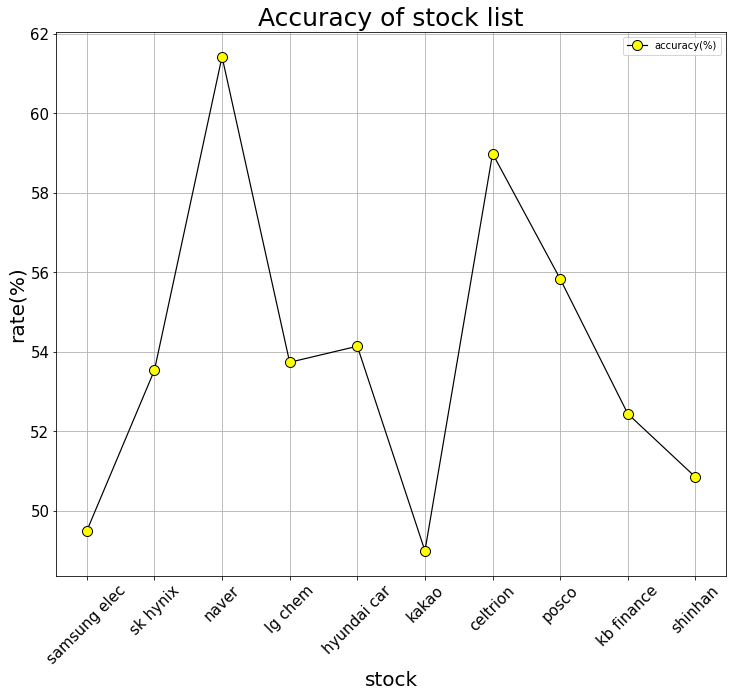

In [86]:
plt.figure(figsize=(12, 10))
plt.plot(acc_df.index, acc_df['accuracy'] * 100,
         label='accuracy(%)',
         linestyle='-',
         linewidth=1.2,
         color='black',
         marker='o',
         markersize=10,
         markerfacecolor='yellow',
         markeredgecolor='black'
)

plt.title('Accuracy of stock list', size=25)
plt.xlabel("stock", size=20)
plt.ylabel("rate(%)", size=20)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(loc='best')
plt.show()

#### 종목별 confusion matrix, classification_report

In [87]:
ten_df[0].name.unique()[0]

'삼성전자'

In [91]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

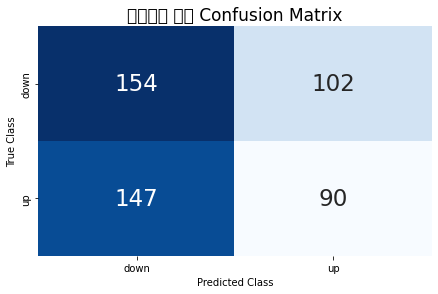

              precision    recall  f1-score   support

        down       0.51      0.60      0.55       256
          up       0.47      0.38      0.42       237

    accuracy                           0.49       493
   macro avg       0.49      0.49      0.49       493
weighted avg       0.49      0.49      0.49       493



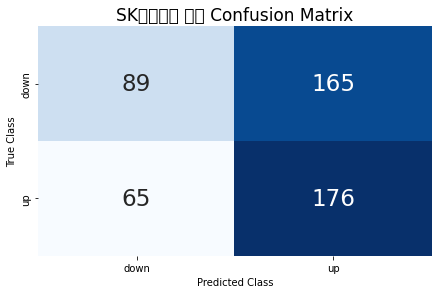

              precision    recall  f1-score   support

        down       0.58      0.35      0.44       254
          up       0.52      0.73      0.60       241

    accuracy                           0.54       495
   macro avg       0.55      0.54      0.52       495
weighted avg       0.55      0.54      0.52       495



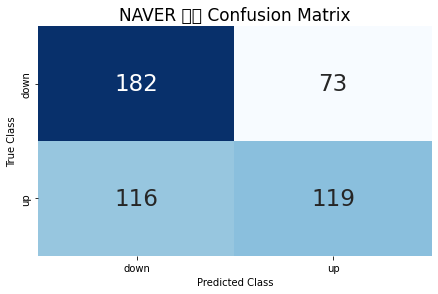

              precision    recall  f1-score   support

        down       0.61      0.71      0.66       255
          up       0.62      0.51      0.56       235

    accuracy                           0.61       490
   macro avg       0.62      0.61      0.61       490
weighted avg       0.62      0.61      0.61       490



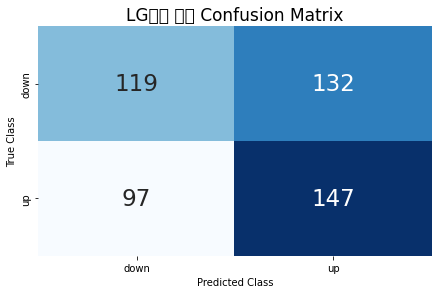

              precision    recall  f1-score   support

        down       0.55      0.47      0.51       251
          up       0.53      0.60      0.56       244

    accuracy                           0.54       495
   macro avg       0.54      0.54      0.54       495
weighted avg       0.54      0.54      0.54       495



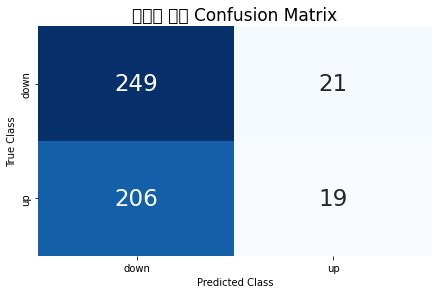

              precision    recall  f1-score   support

        down       0.55      0.92      0.69       270
          up       0.47      0.08      0.14       225

    accuracy                           0.54       495
   macro avg       0.51      0.50      0.42       495
weighted avg       0.51      0.54      0.44       495



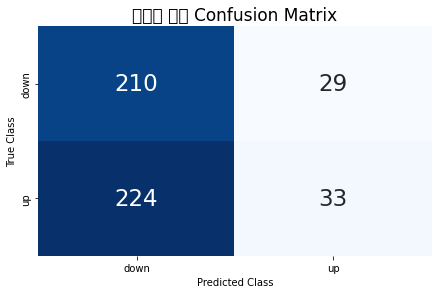

              precision    recall  f1-score   support

        down       0.48      0.88      0.62       239
          up       0.53      0.13      0.21       257

    accuracy                           0.49       496
   macro avg       0.51      0.50      0.42       496
weighted avg       0.51      0.49      0.41       496



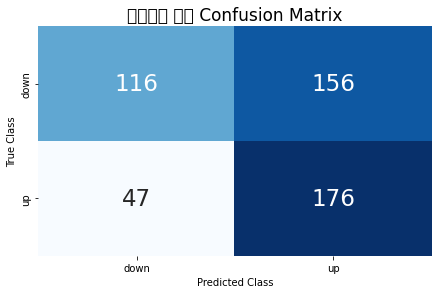

              precision    recall  f1-score   support

        down       0.71      0.43      0.53       272
          up       0.53      0.79      0.63       223

    accuracy                           0.59       495
   macro avg       0.62      0.61      0.58       495
weighted avg       0.63      0.59      0.58       495



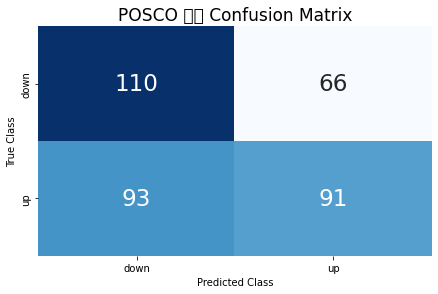

              precision    recall  f1-score   support

        down       0.54      0.62      0.58       176
          up       0.58      0.49      0.53       184

    accuracy                           0.56       360
   macro avg       0.56      0.56      0.56       360
weighted avg       0.56      0.56      0.56       360



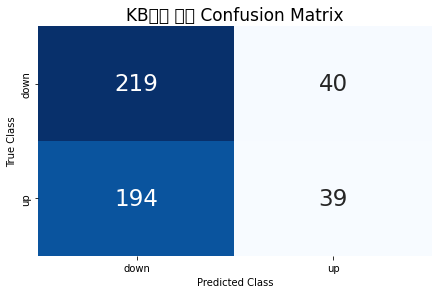

              precision    recall  f1-score   support

        down       0.53      0.85      0.65       259
          up       0.49      0.17      0.25       233

    accuracy                           0.52       492
   macro avg       0.51      0.51      0.45       492
weighted avg       0.51      0.52      0.46       492



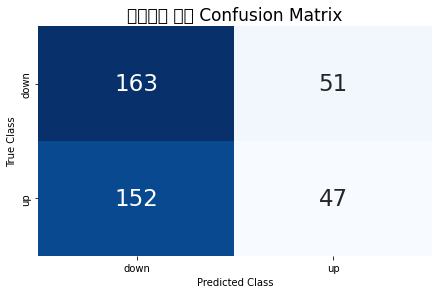

              precision    recall  f1-score   support

        down       0.52      0.76      0.62       214
          up       0.48      0.24      0.32       199

    accuracy                           0.51       413
   macro avg       0.50      0.50      0.47       413
weighted avg       0.50      0.51      0.47       413



In [92]:
def make_confusion_matrix(df):
  matrix = confusion_matrix(df.label, df.predict)
  class_names = ['down', 'up']
  dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

  sns.heatmap(dataframe, annot=True, annot_kws = {'size' : 23}, fmt='d', cbar=None, cmap='Blues')
  name = df.name.unique()[0]
  plt.title(f'{name} 종목 Confusion Matrix',size=17)
  plt.tight_layout()
  plt.ylabel('True Class')
  plt.xlabel('Predicted Class')
  plt.show()
  print(classification_report(df.label, df.predict, target_names=class_names))

for df in ten_df:
  make_confusion_matrix(df)

In [93]:
#acc_list = []; 
precision_up = []; precision_down = []
company = ['samsung elec', 'sk hynix', 'naver', 'lg chem', 'hyundai car', 'kakao', 'celtrion', 'posco', 'kb finance', 'shinhan']
for df in ten_df:
  #acc_list.append(accuracy_score(df['label'], df['predict']))
  precision_up.append(precision_score(df['label'], df['predict'],pos_label=1))
  precision_down.append(precision_score(df['label'], df['predict'],pos_label=0))

In [94]:
pre_up = pd.DataFrame({'company': company, 'precision': precision_up})
pre_down = pd.DataFrame({'company': company, 'precision': precision_down})
pre_up.set_index('company', inplace=True)
pre_down.set_index('company', inplace=True)

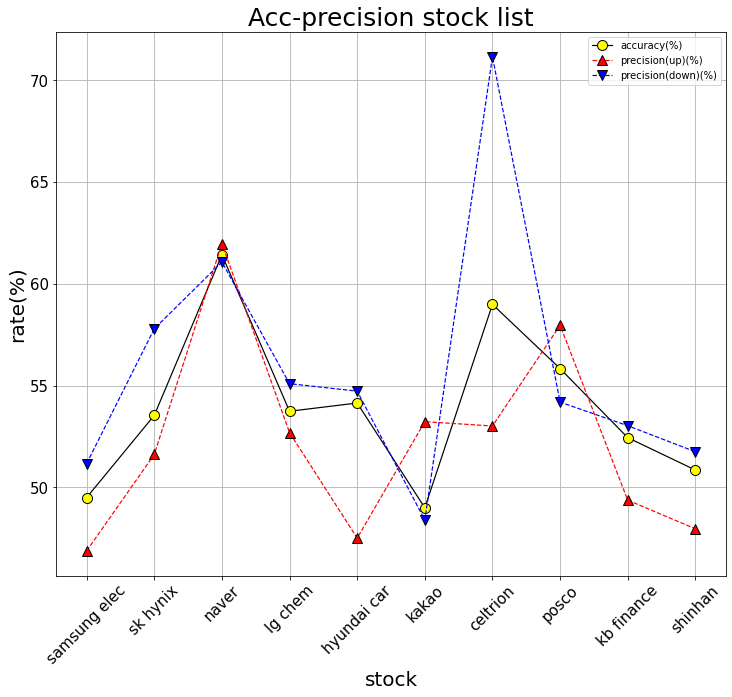

In [95]:
plt.figure(figsize=(12, 10))
plt.plot(acc_df.index, acc_df['accuracy'] * 100,
         label='accuracy(%)',
         linestyle='-',
         linewidth=1.2,
         color='black',
         marker='o',
         markersize=10,
         markerfacecolor='yellow',
         markeredgecolor='black'
)

plt.plot(pre_up.index, pre_up['precision'] * 100,
         label='precision(up)(%)',
         linestyle='--',
         linewidth=1.2,
         color='red',
         marker='^',
         markersize=10,
         markerfacecolor='red',
         markeredgecolor='black'
)

plt.plot(pre_down.index, pre_down['precision'] * 100,
         label='precision(down)(%)',
         linestyle='--',
         linewidth=1.2,
         color='blue',
         marker='v',
         markersize=10,
         markerfacecolor='blue',
         markeredgecolor='black'
)

plt.title('Acc-precision stock list', size=25)
plt.xlabel("stock", size=20)
plt.ylabel("rate(%)", size=20)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(loc='best')
plt.show()